# Analysis of ETKDG NOE Conformer Generation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
unconfined=True

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import SVG, display
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import pandas as pd
import sys
import os
import copy
import tqdm
import itertools
import numpy as np
from itertools import product

# DPep1
from utils import assign_hydrogen_pdbinfo, map_mol_with_noe

# CsA
#from _utils import assign_hydrogen_pdbinfo, map_mol_with_noe

# Setup
Specify file paths:

In [3]:
# CsA
#NOE_PDB_path = "../data/1DP1/21_aligned_2l2x_tol1_noebounds_5400.pdb"
#Baseline_PDB_path = "../data/2L2X/20_2l2x_baseline_5400.pdb"
#OMEGAMC_PDB_path = "../data/2L2X/31_2L2x_OmegaMC_restruct.pdb" # must be restructured according to other mols atom index!
#ref_PDB_path = "../data/2L2X/2l2x.pdb"
#noebounds_path = "../data/2L2X/10_2l2x_chcl3_noebounds.csv"

# CsE
#NOE_PDB_path = "../data/02_CsE/21_CsE_ccl4_corr_noebounds_5400.pdb"
#Baseline_PDB_path = "../data/02_CsE/20_CsE_baseline_5400.pdb"
#OMEGAMC_PDB_path = "../data/02_CsE/32_CsE_OmegaMC_restructured_232.pdb" # must be restructured according to other mols atom index!
#ref_PDB_path = "../data/02_CsE/01_ref.pdb"
#noebounds_path = "../data/02_CsE/11_CsE_ccl4_corr_noebounds.csv"


# DPep1
NOE_PDB_path = "../data/1DP1/21_1dp1_tol1_noebounds_5400.pdb"
Baseline_PDB_path = "../data/1DP1/20_1dp1_baseline_5400.pdb"
OMEGAMC_PDB_path = "../data/1DP1/31_1dp1_OmegaMC_restruct.pdb" # must be restructured according to other mols atom index!
ref_PDB_path = "../data/1DP1/1dp1.pdb"
noebounds_path = "../data/1DP1/10_DPep1_chcl3_noebounds.csv"

# DPep2
#NOE_PDB_path = "../data/12_DPep2/21_DPep2_chcl3_noebounds_5400.pdb"
#Baseline_PDB_path = "../data/12_DPep2/20_DPep2_baseline_5400.pdb"
#OMEGAMC_PDB_path = "../data/12_DPep2/31_DPep2_OmegaMC_restructured_242.pdb" # must be restructured according to other mols atom index!
#ref_PDB_path = "../data/12_DPep2/01_ref_corr.pdb"
#noebounds_path = "../data/12_DPep2/10_DPep2_chcl3_noebounds.csv"

Specify smiles string directly:

In [4]:
#CsA_smiles = "CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C"
#CsE_smiles = "CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C"
DPep1_smiles = "N1[C@@H](CC(C)C)C(=O)N(C)[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N2[C@H](CCC2)C(=O)N(C)[C@@H](Cc2ccccc2)C(=O)N[C@@H](CC(C)C)C(=O)N(C)[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N2[C@H](CCC2)C(=O)N(C)[C@@H]([C@H](O)C)C1=O"
#DPep2_smiles = "N1[C@@H](CC(C)C)C(=O)N(C)[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N2[C@H](CCC2)C(=O)N(C)[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N(C)[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N2[C@H](CCC2)C(=O)N(C)[C@@H](C)C1=O"

smiles = DPep1_smiles

# Distance Calcs

In [5]:
mol = Chem.MolFromPDBFile(NOE_PDB_path, removeHs = False)
bl_mol = Chem.MolFromPDBFile(Baseline_PDB_path, removeHs = False)
omegamc_mol = Chem.MolFromPDBFile(OMEGAMC_PDB_path, removeHs = False)

df = pd.read_csv(noebounds_path, sep = "\s", comment = "#")

mol_atom_names2atom_index, noe_atom_names2mol_atom_names, noe_atom_pair2upper_distance = map_mol_with_noe(mol, df, verbose = False)

index_1, index_2 = [], [] #symmetric, thus two lists are interchangable
labels = []
ref_val = []
res_dist = [] # distance between residuals
bond_dist = [] # number of bonds between atoms

bond_order = Chem.rdmolops.GetDistanceMatrix(mol)

prev_a = 0 
prev_b = 0
num_residues = 0
err = 0

for atom in mol.GetAtoms():
    num_residues = max(num_residues, atom.GetPDBResidueInfo().GetResidueNumber())

for key, val in noe_atom_pair2upper_distance.items():
    try:
        tmp_1 = noe_atom_names2mol_atom_names[key[0]]
        tmp_2 = noe_atom_names2mol_atom_names[key[1]]
        #print(key[0])
        #print(tmp_1)
        a = mol_atom_names2atom_index[tmp_1]
        #print(tmp_2[0])
        b = mol_atom_names2atom_index[tmp_2]
    
        if not(b==prev_a and a==prev_b): # ignore reversed pair
            for item in product(a,b):
                #print(item)
                index_1.append(item[0]) # RDKit indexing starts at 0!
                index_2.append(item[1])
                ref_val.append(val)
            
                r1 = int(tmp_1[0]) # string to int conversion
                r2 = int(tmp_2[0])
                if abs(r1 - r2) <= np.floor(num_residues/2): # take the shorter route along the ring
                    dist = abs(r1 - r2)
                else:
                    dist = abs(abs(r1 - r2) - num_residues)
                res_dist.append(dist)
            
                bd = int(bond_order[item[0], item[1]])
                bond_dist.append(bd)
            
                labels.append("{}-{} {}R {}B {}:{}{}-{}:{}{} ({:0.2f})".format(tmp_1[0], tmp_2[0], dist, bd, item[0], tmp_1[0], 
                                                                tmp_1[1], item[1], tmp_2[0], tmp_2[1], val))
    
        prev_a = a
        prev_b = b
    except:
        err = err + 1

# sort everything for bond_dist (first arg in zip) 
res_dist, bond_dist, labels, ref_val, index_1, index_2 = (list(t) for t in zip(*sorted(zip(bond_dist, res_dist, labels, ref_val, index_1, index_2))))

distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(mol, i) for i in tqdm.tqdm(range(mol.GetNumConformers()))])

with_noe = distance_matrix_for_each_conformer[:, index_1, index_2]

# baseline
distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(bl_mol, i) for i in tqdm.tqdm(range(bl_mol.GetNumConformers()))])
baseline = distance_matrix_for_each_conformer[:, index_1, index_2]

# omegamc
distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(omegamc_mol, i) for i in tqdm.tqdm(range(omegamc_mol.GetNumConformers()))])
omegamc = distance_matrix_for_each_conformer[:, index_1, index_2]

/home/kkajo/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/home/kkajo/Workspace/MacrocycleConfGenNOE/notebooks/utils.py:124: UserWarning: Non-unique mapping between PDB atom ('9', 'HG2') and NOE atoms {('9', 'HG@'), ('9', 'HG2')}.
  warnings.warn("Non-unique mapping between PDB atom {} and NOE atoms {}.".format(key, val))


Pick most probable NOE atom HG2 (yes) or exit (no)? [Y/n] 


  7%|▋         | 376/5400 [00:00<00:01, 3756.13it/s]

Chosen mapping: ('9', 'HG2')   {('9', 'HG2')}


100%|██████████| 214/214 [00:00<00:00, 5130.03it/s]


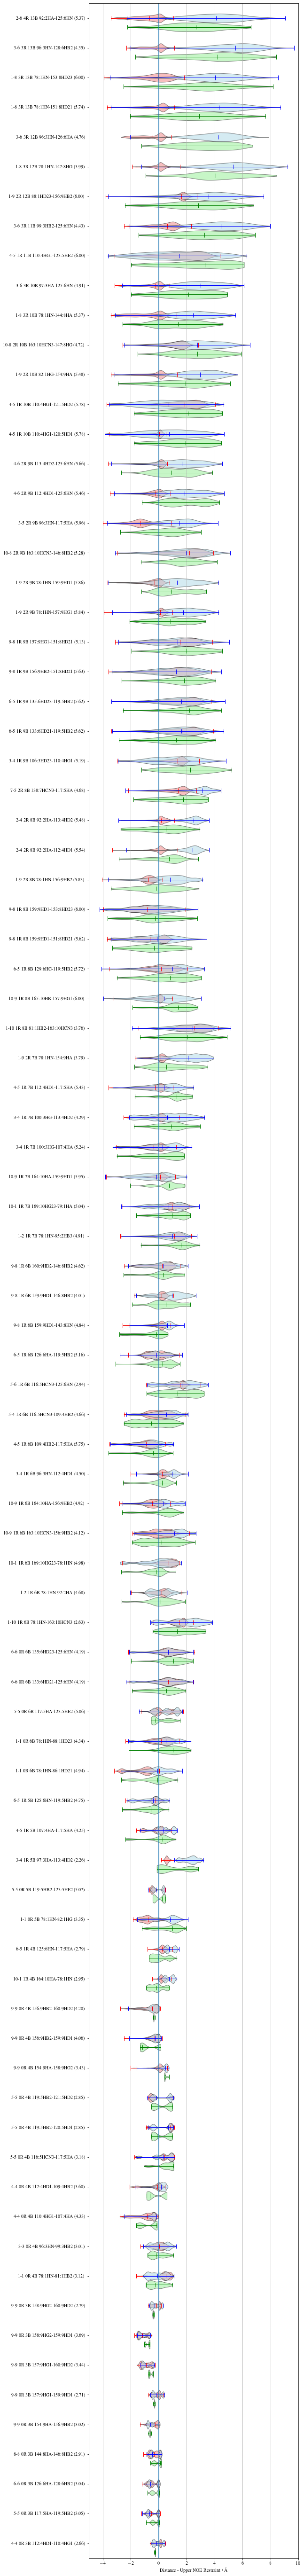

CPU times: user 3 s, sys: 111 ms, total: 3.11 s
Wall time: 2.95 s


In [22]:
plot_1 = copy.copy(with_noe) - ref_val
plot_2 = copy.copy(baseline) - ref_val
plot_3 = copy.copy(omegamc) - ref_val

widths = 0.3
offset = 0.3
fig1, ax1 = plt.subplots(1, 1, figsize = (8,100))
    
def set_violin_color(vp, markercolor, bodycolor):
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vps = vp[partname]
        vps.set_edgecolor(markercolor)
        vps.set_linewidth(1)
    for pc in vp['bodies']:
        pc.set_facecolor(bodycolor)
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
    
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')
green_square = dict(markerfacecolor='g', marker='o')

#bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
#                   flierprops = red_square, positions = np.array(range(plot_1.shape[1])), manage_ticks=False)
vp_1 = ax1.violinplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
                      positions = np.array(range(plot_1.shape[1])), showmeans=False, showmedians=True, 
                      showextrema=True)
vp_2 = ax1.violinplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, 
                      positions = np.array(range(plot_2.shape[1])), showmeans=False, showmedians=True, 
                      showextrema=True)
vp_3 = ax1.violinplot([plot_3[:,i] for i in range(plot_3.shape[1])], vert = False, widths = widths, 
                      positions = np.array(range(plot_3.shape[1])) - offset, showmeans=False, showmedians=True, 
                      showextrema=True)

    
set_violin_color(vp_1, "red", "lightcoral")
set_violin_color(vp_2, "blue", "lightblue")
set_violin_color(vp_3, "green", "lightgreen")

ax1.set_xlabel('Distance - Upper NOE Restraint / Å')
plt.grid(axis = "x", which = "both")
plt.yticks(range(plot_1.shape[1]), labels)
plt.ylim(0 - 0.5, plot_1.shape[1] - 0.5)
plt.xlim(-5, 10)
plt.axvline(x=0)

%time plt.show()

# Visualization of NOE Restraints

In [7]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def plot(NOE, mol):
    drawer = rdMolDraw2D.MolDraw2DSVG(700,550)
    drawer.DrawMolecule(mol_with_atom_index(mol), highlightAtoms=[index_1[NOE], index_2[NOE]])
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    display(SVG(svg))
    
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig = plt.figure(figsize=(700*px,1))
    ax = fig.add_axes([0,0,1,1])
    bp1 = ax.violinplot(with_noe[:,NOE], vert = False, widths = 0.3, showmeans=False, showmedians=True, showextrema=True)
    set_violin_color(bp1, "red", "lightcoral")
    bp2 = ax.violinplot(baseline[:,NOE], vert = False, widths = 0.3, showmeans=False, showmedians=True, showextrema=True)
    set_violin_color(bp2, "blue", "lightblue")
    ax.set_xlabel('Distance / Å')
    ax.set_yticks([])
    plt.grid(axis = "x", which = "both")
    plt.ylim(0.7, 1.3)
    #plt.xlim(0, 8)
    plt.axvline(ref_val[NOE], color="b")
    plt.show()

In [8]:
mol = Chem.MolFromPDBFile(NOE_PDB_path, removeHs = False)
rdDepictor.Compute2DCoords(mol) # remove this to get a crowded 3D-ish representation

interact(plot, NOE = widgets.IntSlider(value=np.floor(len(index_1)/2), min=0, max=len(index_1)-1), mol=fixed(mol))

interactive(children=(IntSlider(value=43, description='NOE', max=85), Output()), _dom_classes=('widget-interac…

<function __main__.plot(NOE, mol)>

# Check if any conformers satisfy all restraints

In [9]:
def restraints_check(conf):
    tmp = copy.copy(conf) - ref_val
    tmp[tmp < 0] = 0
    best_ind = (np.argsort(np.sum(tmp, 1))[:6])

    print("Indices of best: \t\t\t\t{}".format(best_ind))
    least_violation = []
    for i in best_ind:
        least_violation.append(np.sum(tmp,1)[i])
    print("Summed violations of best / A: \t\t\t{}".format(np.around(np.array(least_violation),2)))
    violation_per_bond = [least_violation/len(labels) for least_violation in least_violation]
    print("Summed violations / #bonds considered / A: \t{}".format(np.around(np.array(violation_per_bond),2)))
    if least_violation[0]>0:
        print('No conformer fulfills all NOE restraints')
    return None

In [10]:
print("With NOE restraints:")
restraints_check(with_noe)

print("\nBaseline")
restraints_check(baseline)

print("\nOmega MC")
restraints_check(omegamc)

With NOE restraints:
Indices of best: 				[ 975 3676 4135 1965   52 2207]
Summed violations of best / A: 			[19.57 21.72 21.85 22.65 22.66 22.71]
Summed violations / #bonds considered / A: 	[0.23 0.25 0.25 0.26 0.26 0.26]
No conformer fulfills all NOE restraints

Baseline
Indices of best: 				[  95 2025 3185 1553  385 3272]
Summed violations of best / A: 			[61.87 65.93 66.33 66.85 66.86 67.29]
Summed violations / #bonds considered / A: 	[0.72 0.77 0.77 0.78 0.78 0.78]
No conformer fulfills all NOE restraints

Omega MC
Indices of best: 				[  8 118 134  14 184 100]
Summed violations of best / A: 			[44.32 55.35 55.9  56.51 60.18 60.73]
Summed violations / #bonds considered / A: 	[0.52 0.64 0.65 0.66 0.7  0.71]
No conformer fulfills all NOE restraints


# Calculate RMSD of Conformers

In [11]:
import mdtraj as md
import cpeptools
import tempfile
def get_rmsd(smiles, pdb_path, ref_pdb_path): #not full rmsd, just ring + beta atom rmsd
    smiles_mol = Chem.MolFromSmiles(smiles)
    ref_mol = Chem.MolFromPDBFile(ref_pdb_path)
    mol = Chem.MolFromPDBFile(pdb_path)

    ref_mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol,ref_mol)
    mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol, mol)
    order = list(mol.GetSubstructMatches(ref_mol)[0])
    mol = Chem.RenumberAtoms(mol, order)

    indices = cpeptools.get_largest_ring(ref_mol)
    indices = cpeptools.mol_ops.get_neighbour_indices(ref_mol, indices)
    #assert len(set(indices) - set(cpeptools.get_largest_ring(mol))) == 0, "ring atom indices do not agree"

    tmp_dir = tempfile.mkdtemp()
    ref_pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    # chem add Hs
    Chem.MolToPDBFile(ref_mol, ref_pdb_filename)
    Chem.MolToPDBFile(mol, pdb_filename)

    ref  = md.load(ref_pdb_filename)
    #ref = ref.center_coordinates()
    compare = md.load(pdb_filename)
    #compare = compare.center_coordinates()
    #print(compare, mol.GetNumConformers())
    #print(" {} has {} conformers".format(smiles, len(compare)))


    bb_rmsd = md.rmsd(compare, ref, 0, atom_indices = indices)
    compare = compare.superpose(ref, 0, atom_indices = indices)
    ten_best = compare[np.argsort(bb_rmsd)[:10]]
    return bb_rmsd, compare[np.argmin(bb_rmsd)], ten_best

In [12]:
%time bb_rmsd, tmp, best_NOE = get_rmsd(smiles, NOE_PDB_path, ref_PDB_path)
bl_rmsd, _, best_bl = get_rmsd(smiles, Baseline_PDB_path, ref_PDB_path)
omegamc_rmsd, _, best_omegamc = get_rmsd(smiles, OMEGAMC_PDB_path, ref_PDB_path)

CPU times: user 11.3 s, sys: 291 ms, total: 11.6 s
Wall time: 11.3 s


In [13]:
np.sort(bb_rmsd)[:10]

array([0.13500702, 0.13642646, 0.1364674 , 0.13809422, 0.1395916 ,
       0.1414485 , 0.14178522, 0.14368631, 0.14401637, 0.14466669],
      dtype=float32)

In [14]:
np.sort(bl_rmsd)[:10]

array([0.13471633, 0.15221918, 0.15493879, 0.16033266, 0.16578035,
       0.16615078, 0.16741854, 0.16854021, 0.16939771, 0.17018746],
      dtype=float32)

In [15]:
np.sort(omegamc_rmsd)[:10]

array([0.19533752, 0.20805767, 0.20979573, 0.21292165, 0.219703  ,
       0.22734806, 0.22785476, 0.23017217, 0.23307768, 0.2340847 ],
      dtype=float32)

In [16]:
best_NOE.save("./tmp/NOE_best_rmsd.pdb")
best_bl.save("./tmp/bl_best_rmsd.pdb")
best_omegamc.save("./tmp/omegamc_best_rmsd.pdb")

# Visualization

In [17]:
tmp.save("./tmp/rmsd_tmp.pdb")
#ten_tmp.save("./tmp/rmsd_ten_tmp.pdb")

Compare best to reference

In [18]:
import nglview as nv

view = nv.show_file("./tmp/rmsd_tmp.pdb")
view.add_representation('cartoon', selection='protein', color='black')
view.add_component(ref_PDB_path, color='blue')

view

NGLWidget()

Show variation of the ten best structures

In [19]:
#view2 = nv.show_file("./rmsd_tmp.pdb")

view2 = nv.show_structure_file("./tmp/NOE_best_rmsd.pdb", default_representation=False)
view2.add_component(ref_PDB_path, selection='protein', color='black')
view2.add_representation('licorice', selection='protein', color='atomindex')
view2.center()
view2

NGLWidget()

Atomic structure of best fit

In [20]:
view3 = nv.show_file("./tmp/rmsd_tmp.pdb")
view3.add_cartoon("protein", color_scheme="residueindex")
view3.add_ball_and_stick("protein")
view3

NGLWidget()